In [4]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf
import os
import shutil
import matplotlib.pyplot as plt
#tfds.disable_progress_bar()

In [5]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [6]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [7]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [8]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [9]:
# shuffling the data
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [36]:
# just to avoid any i/o bottleneck
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'I have just read the lead comment for this film that is on the front page with the voting results and cast run down.<br /><br />Why is it that some people can not take a film for what it is supposed to be.<br /><br />This film is supposed to be a light hearted, tonge in cheek, family comedy, things to make the kids laugh and things for the adults, and that is exactly what this film does.<br /><br />I laughed my nuts off at this film, I thought Carey put in a great performance and the whole film (if watched at Christmas) really give you a bit of festive cheer<br /><br />So to all of you film reviewers stop trying to sound like film students and knock every film because it is not "Taxi Driver" or "The Godfather" and take films for what they are supposed to be, entertainment!!'
 b'The famous international conductor Daniel Dar\xc3\xa9us (Michael Nyqvist) has a heart attack with his stressed busy professional life and interrupts his successful career with an early retirement. He 

In [11]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [12]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [13]:
##single lstm layer model
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 138,369
Trainable params: 138,369
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [18]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 40s 91ms/step - loss: 0.6338 - accuracy: 0.5800 - val_loss: 0.4772 - val_accuracy: 0.7573
Epoch 2/10
391/391 [==============================] - 34s 87ms/step - loss: 0.3984 - accuracy: 0.8176 - val_loss: 0.3807 - val_accuracy: 0.8432
Epoch 3/10
391/391 [==============================] - 34s 88ms/step - loss: 0.3436 - accuracy: 0.8489 - val_loss: 0.3394 - val_accuracy: 0.8516
Epoch 4/10
391/391 [==============================] - 35s 88ms/step - loss: 0.3222 - accuracy: 0.8591 - val_loss: 0.3390 - val_accuracy: 0.8401
Epoch 5/10
391/391 [==============================] - 34s 88ms/step - loss: 0.3116 - accuracy: 0.8639 - val_loss: 0.3262 - val_accuracy: 0.8510
Epoch 6/10
391/391 [==============================] - 33s 85ms/step - loss: 0.3067 - accuracy: 0.8662 - val_loss: 0.3236 - val_accuracy: 0.8599
Epoch 7/10
391/391 [==============================] - 34s 88ms/step - loss: 0.3035 - accuracy: 0.8701 - val_loss: 0.3297 - val_accuracy:

In [19]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 20s 50ms/step - loss: 0.3231 - accuracy: 0.8620
Test Loss: 0.3231406509876251
Test Accuracy: 0.8619999885559082


(0.0, 0.6505735442042351)

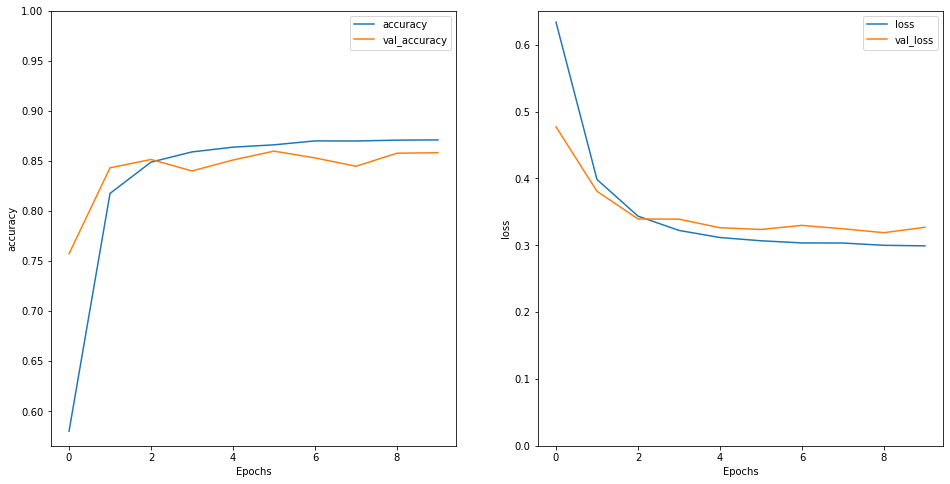

In [20]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [30]:
##Stacking two LSTM layers 
#return sequences is true which means it will return prediction or y hat at each time step of a given sequence
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [31]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [32]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 66s 148ms/step - loss: 0.6047 - accuracy: 0.6043 - val_loss: 0.4134 - val_accuracy: 0.8172
Epoch 2/10
391/391 [==============================] - 55s 140ms/step - loss: 0.3772 - accuracy: 0.8324 - val_loss: 0.3459 - val_accuracy: 0.8391
Epoch 3/10
391/391 [==============================] - 57s 146ms/step - loss: 0.3342 - accuracy: 0.8571 - val_loss: 0.3298 - val_accuracy: 0.8469
Epoch 4/10
391/391 [==============================] - 63s 161ms/step - loss: 0.3207 - accuracy: 0.8628 - val_loss: 0.3275 - val_accuracy: 0.8526
Epoch 5/10
391/391 [==============================] - 63s 160ms/step - loss: 0.3121 - accuracy: 0.8657 - val_loss: 0.3184 - val_accuracy: 0.8568
Epoch 6/10
391/391 [==============================] - 60s 154ms/step - loss: 0.3050 - accuracy: 0.8707 - val_loss: 0.3198 - val_accuracy: 0.8599
Epoch 7/10
391/391 [==============================] - 61s 157ms/step - loss: 0.3050 - accuracy: 0.8713 - val_loss: 0.3150 - val_ac

In [33]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 28s 72ms/step - loss: 0.3142 - accuracy: 0.8607
Test Loss: 0.3141602873802185
Test Accuracy: 0.8607199788093567


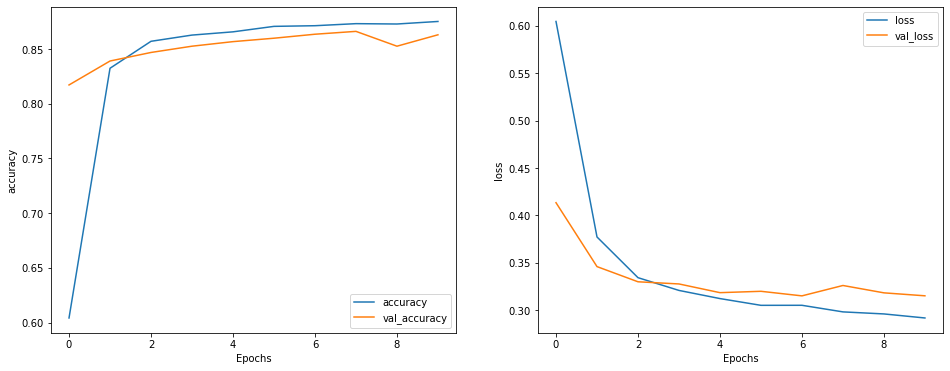

In [34]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')